In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Load

In [2]:
use_cols = ['time','Ambient','EGSPD','VSPD_ajou','TQI_ACOR','TQI','Coolant','VSPD2','Fan_curr','C_Rad_in',
           'C_Head','C_H\C_out','Target_angle','Current_angle']
target_cols = ['C_Head']

In [3]:
args = {'sep':'\t','skiprows':[1],'usecols':use_cols}

df_0421 = pd.read_csv('data/0421mode_변환/ftp_p1p2_Converted.txt',**args).append\
([pd.read_csv('data/0421mode_변환/ftp_p3_Converted.txt',**args),
pd.read_csv('data/0421mode_변환/hwy_Converted.txt',**args) ],ignore_index=True).dropna().reset_index(drop=True)

df_0422 = pd.read_csv('data/0422mode_변환/ftp75_p1p2_Etas.txt',**args).append\
([pd.read_csv('data/0422mode_변환/ftp75_p3_Etas.txt',**args),
pd.read_csv('data/0422mode_변환/hwy_Etas.txt',**args) ],ignore_index=True).dropna().reset_index(drop=True)

df_0423 = pd.read_csv('data/0423mode_변환/ftp75_p1p2_Etas.txt',**args).append\
([pd.read_csv('data/0423mode_변환/ftp75_p3_Etas.txt',**args),
pd.read_csv('data/0423mode_변환/hwy_Etas.txt',**args) ],ignore_index=True).dropna().reset_index(drop=True)

df_0424 = pd.read_csv('data/0424mode_변환/ftp75_p1p2_Etas.txt',**args).append\
([pd.read_csv('data/0424mode_변환/ftp75_p3_Etas.txt',**args),
pd.read_csv('data/0424mode_변환/hwy_Etas.txt',**args) ],ignore_index=True).dropna().reset_index(drop=True)

df_0620 = pd.read_csv('data/realway_변환/morning_0620.txt',**args).dropna().reset_index(drop=True)
df_0621 = pd.read_csv('data/realway_변환/morning_0621.txt',**args).dropna().reset_index(drop=True)

In [9]:
def make_data(df,window_size,pred_t,time_step=True):
    raw_X = df.drop(target_cols,axis=1).values
    raw_Y = df[target_cols].values
    temp = window_size+pred_t
    X = []
    for i in range(raw_X.shape[0]-window_size):
        subset = raw_X[i:(i+window_size)]
        X.append(subset.reshape(-1))

    X = np.array(X)
    Y = raw_Y[temp-1:]
    return X,Y

In [10]:
window_size = 10
pred_t = 1

X,Y = make_data(df_0421,window_size,pred_t)
for df in [df_0422,df_0423,df_0424,df_0620,df_0621]:
    X_,Y_ = make_data(df_0421,window_size,pred_t)
    X=np.append(X,X_,axis=0)
    Y=np.append(Y,Y_,axis=0)

In [11]:
X = np.reshape(X,(-1,window_size,13))

In [12]:
X.shape,Y.shape

((2103912, 10, 13), (2103912, 1))

# Build Model

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape = (window_size, 13)))
lstm_model.add(Dense(1))
lstm_model.compile(loss="mse", optimizer="adam")

In [16]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72704     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 72,833
Trainable params: 72,833
Non-trainable params: 0
_________________________________________________________________


In [17]:
early_stopping = EarlyStopping(patience=5)
lstm_model.fit(X,Y,epochs=100,batch_size=64,validation_split=0.7,shuffle=True,callbacks=[early_stopping])

Epoch 1/100
9863/9863 [==============================] - 87s 9ms/step - loss: 368.5901 - val_loss: 9.0301
Epoch 2/100
9863/9863 [==============================] - 152s 15ms/step - loss: 9.4233 - val_loss: 7.0072
Epoch 3/100
9863/9863 [==============================] - 137s 14ms/step - loss: 7.2732 - val_loss: 6.9949
Epoch 4/100
9863/9863 [==============================] - 166s 17ms/step - loss: 5.6067 - val_loss: 3.6239
Epoch 5/100
9863/9863 [==============================] - 184s 19ms/step - loss: 4.1331 - val_loss: 3.3000
Epoch 6/100
9863/9863 [==============================] - 118s 12ms/step - loss: 3.3023 - val_loss: 2.8000
Epoch 7/100
9863/9863 [==============================] - 80s 8ms/step - loss: 2.7580 - val_loss: 1.5116
Epoch 8/100
9863/9863 [==============================] - 86s 9ms/step - loss: 2.3773 - val_loss: 1.5902
Epoch 9/100
9863/9863 [==============================] - 81s 8ms/step - loss: 2.1552 - val_loss: 1.6927
Epoch 10/100
9863/9863 [============================

# df_0423 데이터 예측해보기

In [21]:
X,Y = make_data(df_0421,window_size,pred_t)
X = np.reshape(X,(-1,window_size,13))

In [22]:
pred_Y = lstm_model.predict(X)

/home/tactics/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


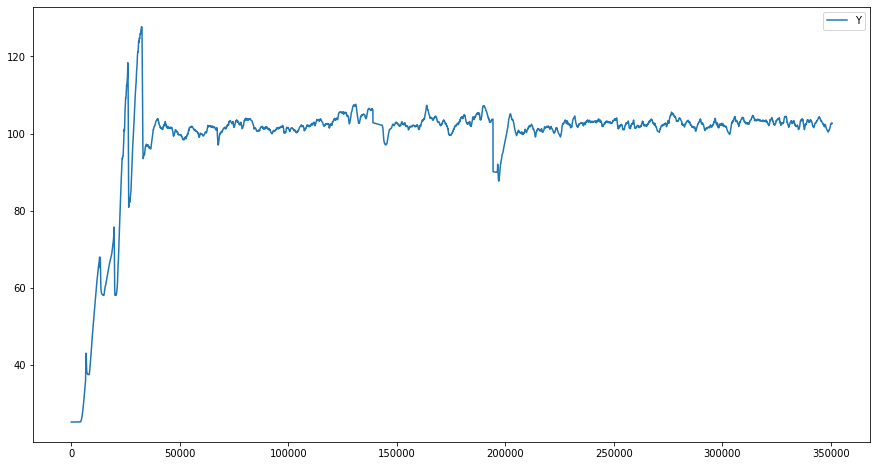

In [23]:
plt.figure(figsize=(15,8))
plt.plot(Y,label='Y')
plt.legend()
plt.show()

/home/tactics/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


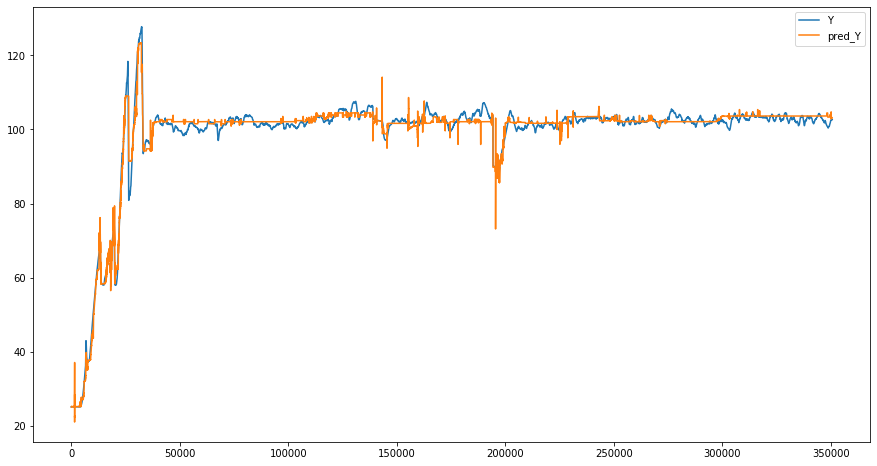

In [24]:
plt.figure(figsize=(15,8))
plt.plot(Y,label='Y')
plt.plot(pred_Y,label='pred_Y')
plt.legend()
plt.show()